In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Pg 145
# J&J Quarterly EPS since January 1960 to  december 1980
df = pd.read_csv('../data/jj.csv')
df.tail() # shape (84, 2)

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [3]:
train = df.iloc[:-4]
test= df.iloc[-4:]

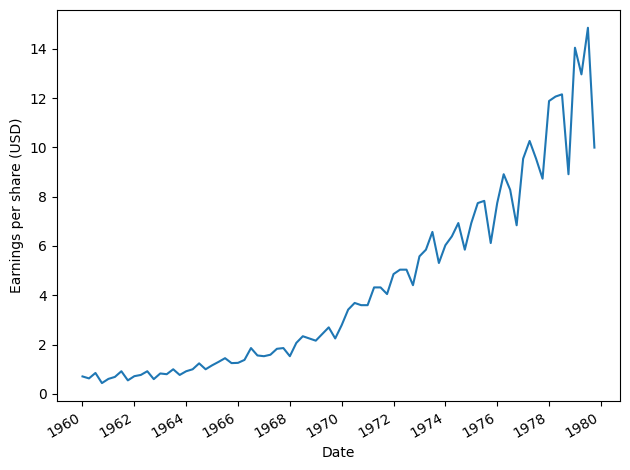

In [4]:
# Figure 7.5 in pg 147

fig, ax = plt.subplots()

ax.plot(train.date, train['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()


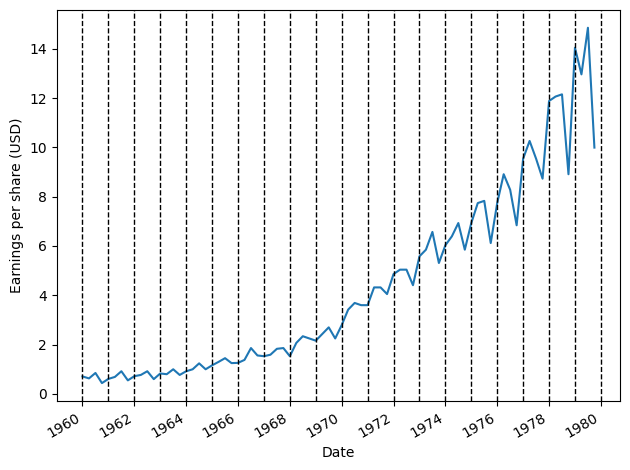

In [5]:
fig, ax = plt.subplots()

ax.plot(train.date, train['data'])
for i in np.arange(0, 84, 4):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 84, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

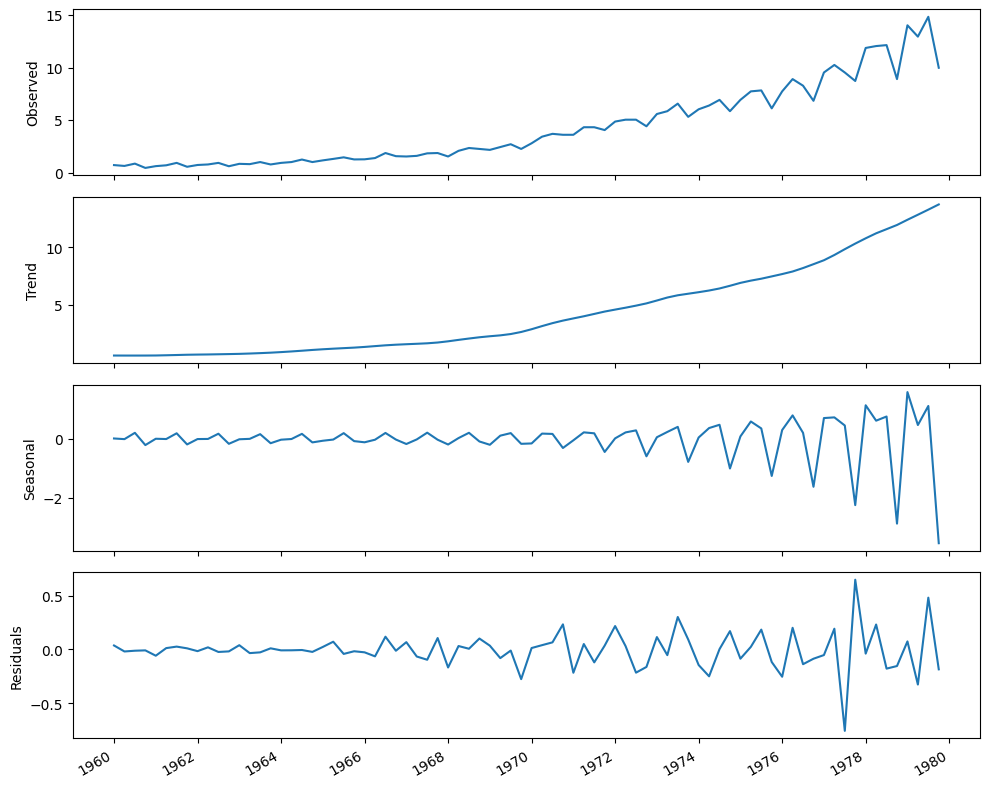

In [6]:
decomposition = STL(train['data'], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 84, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
ad_fuller_result = adfuller(train['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 4.990525443391484
p-value: 1.0


In [8]:
df_seasonal_diff = np.diff(train['data'], n=4)

ad_fuller_result = adfuller(df_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.171368012578263
p-value: 1.0055903310040308e-05


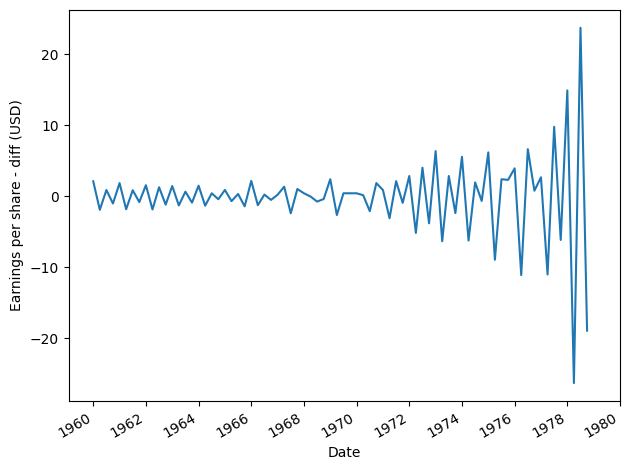

In [9]:
fig, ax = plt.subplots()

ax.plot(train['date'][4:], df_seasonal_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## d=0, D=1

In [10]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

d = 0
D = 1
s = 4

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

SARIMA_result_df = optimize_SARIMA(train['data'], SARIMA_order_list, d, D, s)
SARIMA_result_df

***************************************************************************
Pick a Model and analyze residuals

We pick SARIMA(2,0,2)(1,1,4)_4, which has the lowest AIC

In [13]:
SARIMA_model = SARIMAX(train['data'], order=(2,0,2), seasonal_order=(1,1,4,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='powell')#, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                          SARIMAX Results                                           
Dep. Variable:                                         data   No. Observations:                   80
Model:             SARIMAX(2, 0, 2)x(1, 1, [1, 2, 3, 4], 4)   Log Likelihood                 -38.475
Date:                                      Tue, 10 Feb 2026   AIC                             96.950
Time:                                              22:27:49   BIC                            120.258
Sample:                                                   0   HQIC                           106.265
                                                       - 80                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0271      0.154  

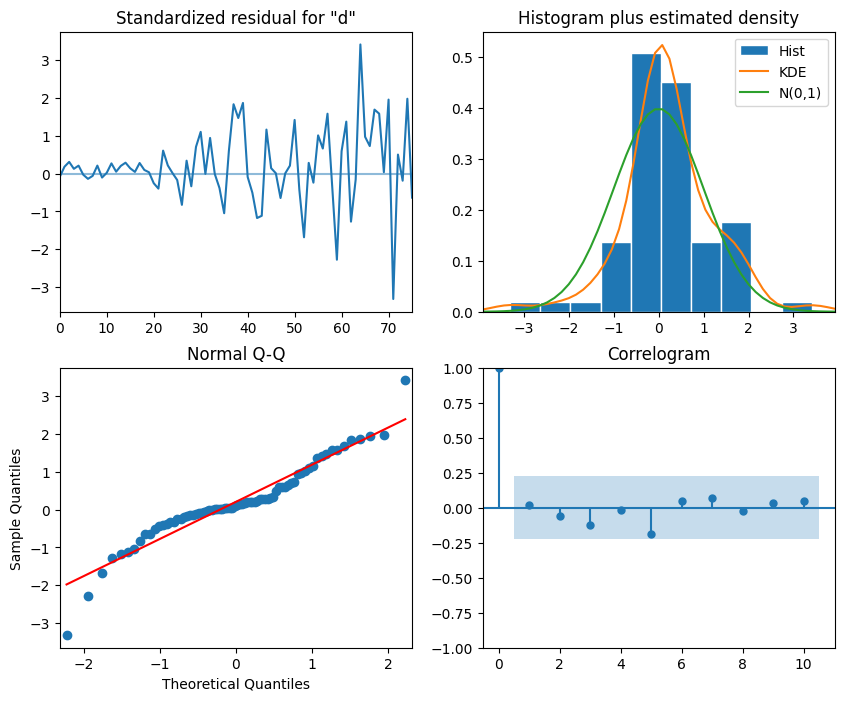

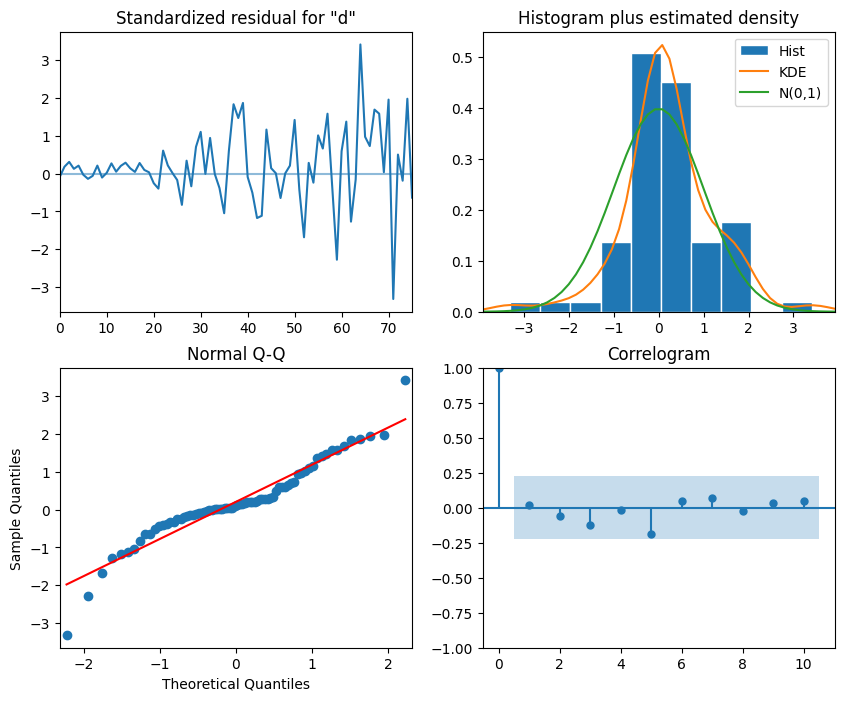

In [14]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [15]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.721968,0.395499
2,0.729486,0.694375
3,1.501425,0.681941
4,1.535863,0.820270
5,3.986750,0.551325
6,4.115422,0.661060
7,4.327079,0.741427
8,4.439355,0.815469
9,4.457460,0.878813
10,4.542745,0.919560


SARIMA(2,0,2)(1,1,4)_4, , Ljung-Box test, coefficients uncorrelated  
Let's try, SARIMA(2,0,2)(0,1,0)_4

In [16]:
SARIMA_model = SARIMAX(train['data'], order=(2,0,2), seasonal_order=(0,1,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)#, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   80
Model:             SARIMAX(2, 0, 2)x(0, 1, [], 4)   Log Likelihood                 -42.246
Date:                            Tue, 10 Feb 2026   AIC                             94.492
Time:                                    22:28:44   BIC                            106.146
Sample:                                         0   HQIC                            99.149
                                             - 80                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0407      0.200      0.203      0.839      -0.352       0.433
ar.L2          0.9457      0.192   

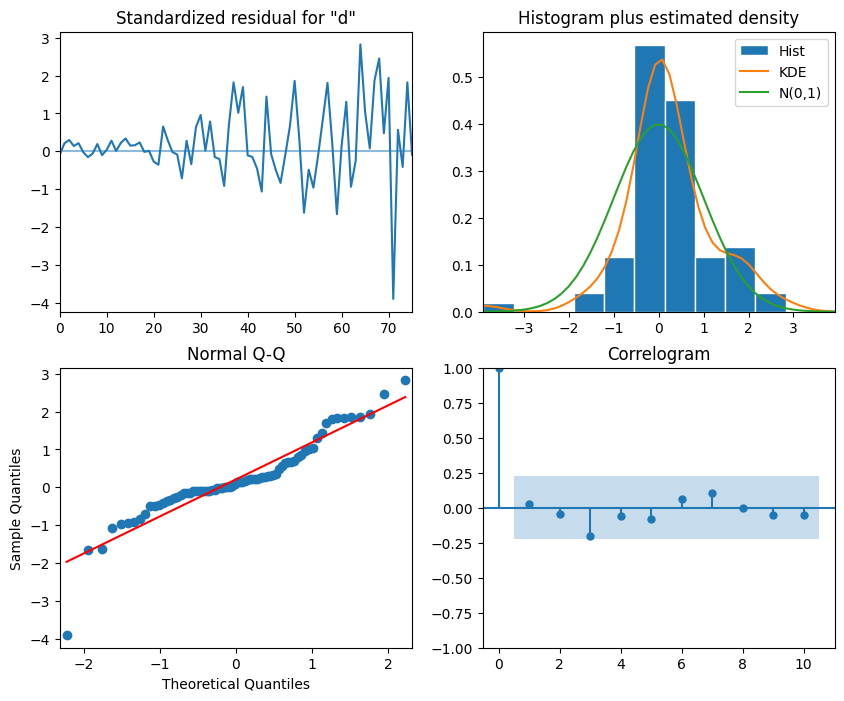

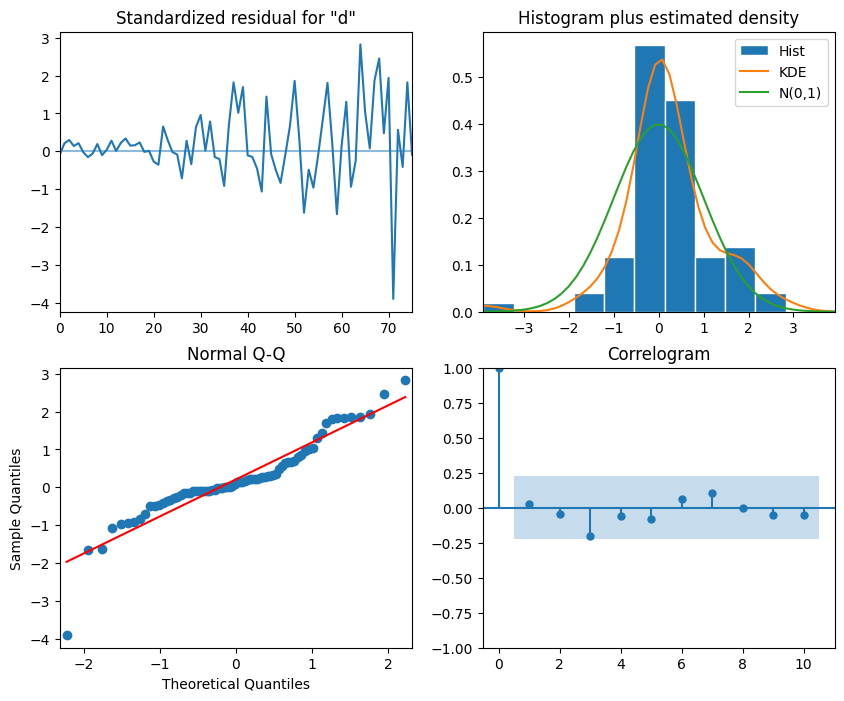

In [17]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [18]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.674103,0.411625
2,0.674244,0.713822
3,3.032076,0.386706
4,3.306490,0.507905
5,3.764676,0.583769
6,4.035339,0.671894
7,4.697158,0.696864
8,4.719085,0.787135
9,5.096309,0.825833
10,5.443510,0.859654


SARIMA(2,0,2)(0,1,0)_4, , Ljung-Box test, coefficients uncorrelated  
Let's try, SARIMA(2,0,4)(2,1,0)_4

In [19]:
SARIMA_model = SARIMAX(train['data'], order=(2,0,4), seasonal_order=(2,1,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)#, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   80
Model:             SARIMAX(2, 0, 4)x(2, 1, [], 4)   Log Likelihood                 -38.381
Date:                            Tue, 10 Feb 2026   AIC                             94.763
Time:                                    22:29:16   BIC                            115.740
Sample:                                         0   HQIC                           103.146
                                             - 80                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2060      0.107      1.917      0.055      -0.005       0.417
ar.L2          0.7792      0.108   

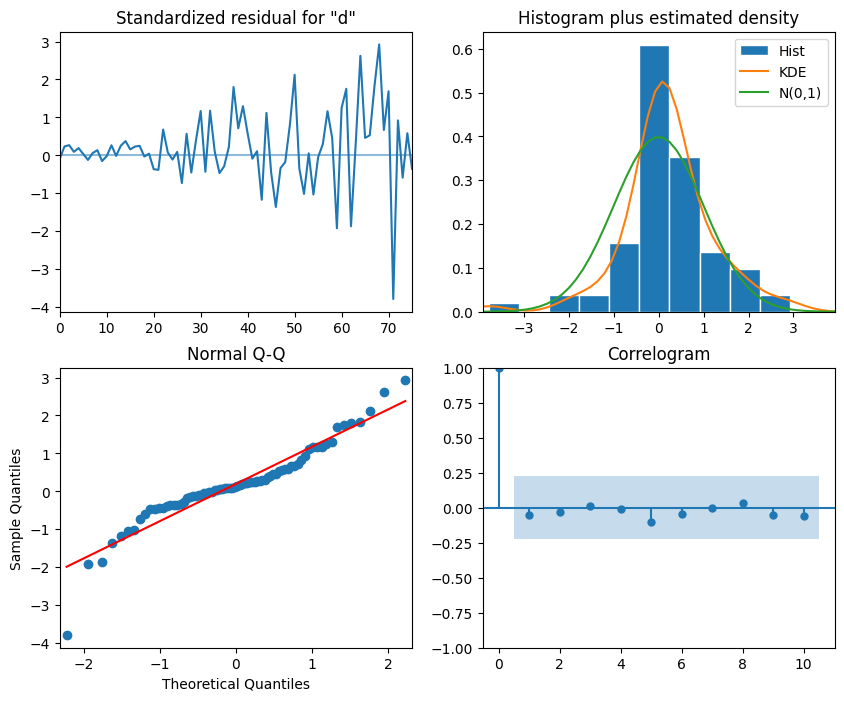

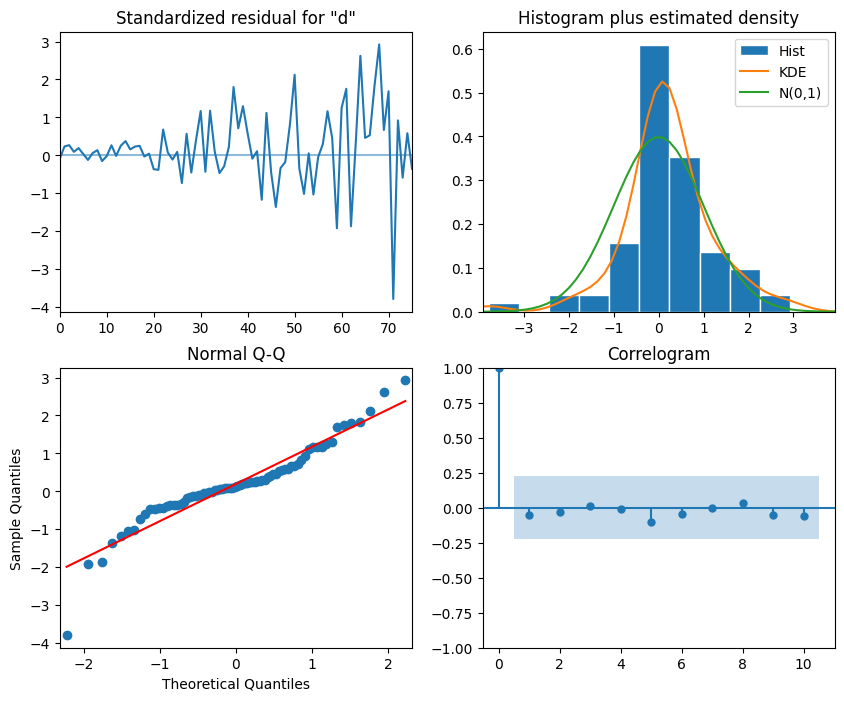

In [20]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [21]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.060130,0.806290
2,0.074004,0.963674
3,0.130551,0.987935
4,0.158436,0.997023
5,0.849357,0.973779
6,1.004120,0.985456
7,1.020827,0.994486
8,1.052120,0.997897
9,1.394809,0.997854
10,1.780649,0.997762


Coefficients uncorrelated

We pick SARIMA(2,0,2)(1,1,4)_4, which has the lowest AIC

*******************************************************************************************
Forecast with model

In [25]:
SARIMA_model = SARIMAX(train['data'], order=(2,0,2), seasonal_order=(1,1,4,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='powell')#, method='nm') # method='powell'

#print(SARIMA_model_fit.summary())

In [26]:
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [27]:
SARIMA_pred = SARIMA_model_fit.get_prediction(80, 84).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,date,data,naive_seasonal,SARIMA_pred
80,1980-01-01,16.20,14.04,16.662899
81,1980-04-01,14.67,12.96,14.047717
82,1980-07-02,16.02,14.85,17.554289
83,1980-10-01,11.61,9.99,11.248937


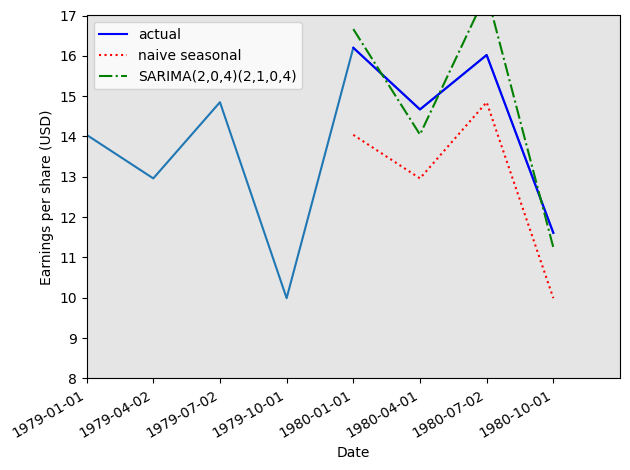

In [28]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
#ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,0,4)(2,1,0,4)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(75, 84, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(76, 84)
ax.set_ylim(8, 17)

fig.autofmt_xdate()
plt.tight_layout()


In [29]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_SARIMA)

11.561658552433654 4.9466354556255805


SARIMA(2,0,2)(1,1,4)_4 needed method='powell', 4.95% off. Let's try next AIC one: SARIMA(2,0,2)(0,1,0)_4

In [31]:
SARIMA_model = SARIMAX(train['data'], order=(2,0,2), seasonal_order=(0,1,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)#, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   80
Model:             SARIMAX(2, 0, 2)x(0, 1, [], 4)   Log Likelihood                 -42.246
Date:                            Tue, 10 Feb 2026   AIC                             94.492
Time:                                    22:33:18   BIC                            106.146
Sample:                                         0   HQIC                            99.149
                                             - 80                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0407      0.200      0.203      0.839      -0.352       0.433
ar.L2          0.9457      0.192   

In [32]:
SARIMA_pred = SARIMA_model_fit.get_prediction(80, 84).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,date,data,naive_seasonal,SARIMA_pred
80,1980-01-01,16.20,14.04,16.264876
81,1980-04-01,14.67,12.96,14.090585
82,1980-07-02,16.02,14.85,17.000086
83,1980-10-01,11.61,9.99,11.146754


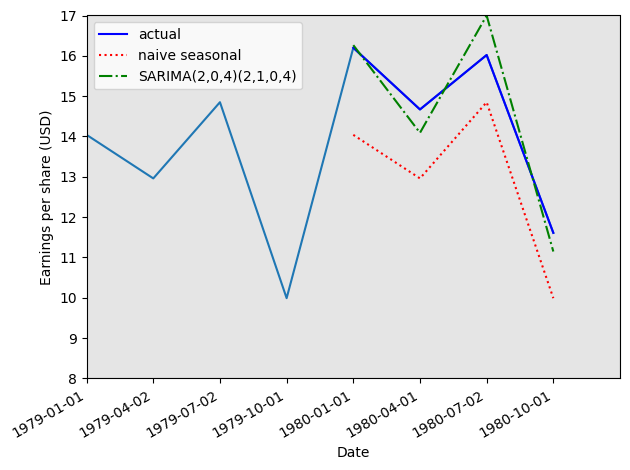

In [34]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
#ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,0,4)(2,1,0,4)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(75, 84, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(76, 84)
ax.set_ylim(8, 17)

fig.autofmt_xdate()
plt.tight_layout()

In [33]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_SARIMA)

11.561658552433654 3.614521268494114


SARIMA(2,0,2)(0,1,0)_4, method=_, 3.61% off